## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore') 

C:\Users\OH\Anaconda3\envs\pytorch1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Hyperparameter Setting

In [3]:
CFG = {
    'CROP_SIZE':286,
    'IMG_SIZE':224,
    'EPOCHS':100,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [5]:
df = pd.read_csv('./train.csv')
df

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,./train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,./train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32989,TRAIN_32989,./train/TRAIN_32989.jpg,1,0,0,0,1,0,1,1,1,1
32990,TRAIN_32990,./train/TRAIN_32990.jpg,1,0,0,0,0,1,1,1,1,1
32991,TRAIN_32991,./train/TRAIN_32991.jpg,1,0,0,0,0,1,1,1,1,1
32992,TRAIN_32992,./train/TRAIN_32992.jpg,1,0,0,0,0,1,1,1,1,1


## Train / Validation Split

In [6]:
df = df.sample(frac=1)
train_len = int(len(df) * 0.8)

In [7]:
train = df[:train_len]
val = df[train_len:]

## Data Preprocessing

In [8]:
def get_labels(df):
    return df.iloc[:,2:].values

In [9]:
train_labels = get_labels(train)
val_labels = get_labels(val)

## CustomDataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [11]:
train_transform = A.Compose([
                            A.Resize(CFG['CROP_SIZE'],CFG['CROP_SIZE']),
                            A.CenterCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            # A.Defocus(p = 0.5),
                            # A.Affine(p = 0.5),
                            # A.ShiftScaleRotate(p = 0.5),
                            # A.ElasticTransform(p = 0.5),
                            # A.GaussNoise(p = 0.5),
                            # A.GridDistortion(p = 0.5),
                            # A.OpticalDistortion(p = 0.5),
                            A.Rotate(p = 0.5),
                            A.Blur(p = 0.5),
                            A.Normalize(mean=(0.436, 0.499, 0.567), std=(0.215, 0.231, 0.242), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

                            

test_transform = A.Compose([
                            A.Resize(CFG['CROP_SIZE'],CFG['CROP_SIZE']),
                            A.CenterCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.436, 0.499, 0.567), std=(0.215, 0.231, 0.242), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [12]:
train_dataset = CustomDataset(train['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224]) torch.Size([3, 224, 224]) <built-in method reshape of Tensor object at 0x00000139FE7CD090>


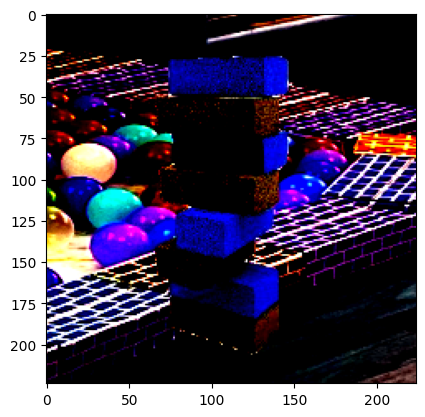

In [13]:
# Invalid shape (27, 3, 224, 224) for image data
# Invalid shape (3, 224, 224) for image data

from matplotlib import pyplot as plt

train_dataset = CustomDataset(train['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

for image, _ in train_loader:
    print(image.shape, image[0].shape, image[0].reshape(224,224,3).reshape)
    break

plt.imshow(image[0].permute((1,2,0)))

In [14]:
# image.shape

In [15]:
# print(image)
# image = image.detach().cpu().numpy()
# print(image[0,:,:,:])

In [16]:
# import timm 
# timm.list_models()

## Model Define

In [17]:
import timm
class BaseModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseModel, self).__init__()
        self.backbone = timm.create_model("resnext50_32x4d", num_classes = 1000, pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = F.sigmoid(self.classifier(x))
        return x

## Train

In [18]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    cnt = 0
    best_loss = np.inf
    best_val_acc = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_acc = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.7f}] Val Loss : [{_val_loss:.7f}] Val ACC : [{_val_acc:.7f}]')
        
        if scheduler is not None:
            scheduler.step(_val_acc)

        if best_val_acc <= _val_acc:
            best_val_acc = _val_acc
            best_model = model
            torch.save(model.state_dict(), 'C:/Users/OH/python/Dacon/4Dblock/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved')
            cnt = 0
                        
        if best_val_acc > _val_acc:
            cnt = cnt + 1
            print('cnt : ' , cnt)
            if cnt > 10:
                break

In [19]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            val_acc.append(batch_acc)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_acc = np.mean(val_acc)
    
    return _val_loss, _val_acc

## Run!!

In [20]:
model = BaseModel()
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:35<00:00,  5.90it/s]


Epoch [1], Train Loss : [0.6243967] Val Loss : [0.3681511] Val ACC : [0.8192978]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:30<00:00,  6.68it/s]


Epoch [2], Train Loss : [0.2558685] Val Loss : [0.1622665] Val ACC : [0.9384295]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.66it/s]


Epoch [3], Train Loss : [0.1485520] Val Loss : [0.1034874] Val ACC : [0.9596575]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:30<00:00,  6.70it/s]


Epoch [4], Train Loss : [0.1162236] Val Loss : [0.0875132] Val ACC : [0.9654029]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.67it/s]


Epoch [5], Train Loss : [0.0972971] Val Loss : [0.0741944] Val ACC : [0.9714329]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:30<00:00,  6.73it/s]


Epoch [6], Train Loss : [0.0863787] Val Loss : [0.0642186] Val ACC : [0.9754896]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.66it/s]


Epoch [7], Train Loss : [0.0774307] Val Loss : [0.0568156] Val ACC : [0.9777001]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.31it/s]


Epoch [8], Train Loss : [0.0682247] Val Loss : [0.0606472] Val ACC : [0.9766132]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.12it/s]


Epoch [9], Train Loss : [0.0654363] Val Loss : [0.0545485] Val ACC : [0.9795570]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.60it/s]


Epoch [10], Train Loss : [0.0588232] Val Loss : [0.0527154] Val ACC : [0.9799819]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.22it/s]


Epoch [11], Train Loss : [0.0537724] Val Loss : [0.0500327] Val ACC : [0.9807432]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.38it/s]


Epoch [12], Train Loss : [0.0506488] Val Loss : [0.0487241] Val ACC : [0.9818517]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:35<00:00,  5.85it/s]


Epoch [13], Train Loss : [0.0481608] Val Loss : [0.0476429] Val ACC : [0.9820113]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.05it/s]


Epoch [14], Train Loss : [0.0448920] Val Loss : [0.0501106] Val ACC : [0.9815347]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  5.98it/s]


Epoch [15], Train Loss : [0.0425490] Val Loss : [0.0483680] Val ACC : [0.9824944]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  5.92it/s]


Epoch [16], Train Loss : [0.0402405] Val Loss : [0.0533457] Val ACC : [0.9821019]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.02it/s]


Epoch [17], Train Loss : [0.0379242] Val Loss : [0.0413215] Val ACC : [0.9842542]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:36<00:00,  5.61it/s]


Epoch [18], Train Loss : [0.0370090] Val Loss : [0.0506377] Val ACC : [0.9824577]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.16it/s]


Epoch [19], Train Loss : [0.0346479] Val Loss : [0.0385634] Val ACC : [0.9860939]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.13it/s]


Epoch [20], Train Loss : [0.0332969] Val Loss : [0.0419040] Val ACC : [0.9854684]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.05it/s]


Epoch [21], Train Loss : [0.0329343] Val Loss : [0.0442589] Val ACC : [0.9850845]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.10it/s]


Epoch [22], Train Loss : [0.0313228] Val Loss : [0.0400804] Val ACC : [0.9850220]
Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.
cnt :  3


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.09it/s]


Epoch [23], Train Loss : [0.0177284] Val Loss : [0.0310150] Val ACC : [0.9892577]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.28it/s]


Epoch [24], Train Loss : [0.0153700] Val Loss : [0.0321014] Val ACC : [0.9888803]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.10it/s]


Epoch [25], Train Loss : [0.0139538] Val Loss : [0.0316808] Val ACC : [0.9891520]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.16it/s]


Epoch [26], Train Loss : [0.0150445] Val Loss : [0.0353426] Val ACC : [0.9889105]
Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.
cnt :  3


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.15it/s]


Epoch [27], Train Loss : [0.0099163] Val Loss : [0.0308280] Val ACC : [0.9906617]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.17it/s]


Epoch [28], Train Loss : [0.0087591] Val Loss : [0.0327263] Val ACC : [0.9901937]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.02it/s]


Epoch [29], Train Loss : [0.0078476] Val Loss : [0.0328280] Val ACC : [0.9903899]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.37it/s]


Epoch [30], Train Loss : [0.0077148] Val Loss : [0.0308903] Val ACC : [0.9909722]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.44it/s]


Epoch [31], Train Loss : [0.0073682] Val Loss : [0.0320641] Val ACC : [0.9904438]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.52it/s]


Epoch [32], Train Loss : [0.0077286] Val Loss : [0.0297587] Val ACC : [0.9908277]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.37it/s]


Epoch [33], Train Loss : [0.0067973] Val Loss : [0.0312386] Val ACC : [0.9907436]
Epoch 00033: reducing learning rate of group 0 to 1.2500e-04.
cnt :  3


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.51it/s]


Epoch [34], Train Loss : [0.0052531] Val Loss : [0.0339814] Val ACC : [0.9912202]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.07it/s]


Epoch [35], Train Loss : [0.0043217] Val Loss : [0.0362895] Val ACC : [0.9914920]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.30it/s]


Epoch [36], Train Loss : [0.0043641] Val Loss : [0.0376405] Val ACC : [0.9913712]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.04it/s]


Epoch [37], Train Loss : [0.0040097] Val Loss : [0.0340076] Val ACC : [0.9913259]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:30<00:00,  6.74it/s]


Epoch [38], Train Loss : [0.0040231] Val Loss : [0.0350146] Val ACC : [0.9912353]
Epoch 00038: reducing learning rate of group 0 to 6.2500e-05.
cnt :  3


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.60it/s]


Epoch [39], Train Loss : [0.0036657] Val Loss : [0.0370477] Val ACC : [0.9914014]
cnt :  4


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  6.00it/s]


Epoch [40], Train Loss : [0.0030610] Val Loss : [0.0371810] Val ACC : [0.9915071]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:34<00:00,  5.96it/s]


Epoch [41], Train Loss : [0.0030858] Val Loss : [0.0369852] Val ACC : [0.9911448]
Epoch 00041: reducing learning rate of group 0 to 3.1250e-05.
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:32<00:00,  6.28it/s]


Epoch [42], Train Loss : [0.0027962] Val Loss : [0.0360297] Val ACC : [0.9914165]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.18it/s]


Epoch [43], Train Loss : [0.0024649] Val Loss : [0.0358880] Val ACC : [0.9916516]
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:33<00:00,  6.17it/s]


Epoch [44], Train Loss : [0.0026482] Val Loss : [0.0361699] Val ACC : [0.9914467]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.62it/s]


Epoch [45], Train Loss : [0.0026389] Val Loss : [0.0363349] Val ACC : [0.9915373]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.61it/s]


Epoch [46], Train Loss : [0.0024740] Val Loss : [0.0367950] Val ACC : [0.9914920]
Epoch 00046: reducing learning rate of group 0 to 1.5625e-05.
cnt :  3


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.56it/s]


Epoch [47], Train Loss : [0.0022254] Val Loss : [0.0369923] Val ACC : [0.9916128]
cnt :  4


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.57it/s]


Epoch [48], Train Loss : [0.0021607] Val Loss : [0.0378761] Val ACC : [0.9915826]
cnt :  5


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.61it/s]


Epoch [49], Train Loss : [0.0021288] Val Loss : [0.0373793] Val ACC : [0.9917335]
Epoch 00049: reducing learning rate of group 0 to 7.8125e-06.
Model Saved


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.55it/s]


Epoch [50], Train Loss : [0.0021243] Val Loss : [0.0378656] Val ACC : [0.9916580]
cnt :  1


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.55it/s]


Epoch [51], Train Loss : [0.0021664] Val Loss : [0.0390913] Val ACC : [0.9915977]
cnt :  2


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.59it/s]


Epoch [52], Train Loss : [0.0018351] Val Loss : [0.0391397] Val ACC : [0.9915977]
Epoch 00052: reducing learning rate of group 0 to 3.9063e-06.
cnt :  3


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.53it/s]


Epoch [53], Train Loss : [0.0019105] Val Loss : [0.0379859] Val ACC : [0.9915826]
cnt :  4


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:30<00:00,  6.72it/s]


Epoch [54], Train Loss : [0.0018665] Val Loss : [0.0396383] Val ACC : [0.9915071]
cnt :  5


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.51it/s]


Epoch [55], Train Loss : [0.0020567] Val Loss : [0.0381344] Val ACC : [0.9917033]
Epoch 00055: reducing learning rate of group 0 to 1.9531e-06.
cnt :  6


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.48it/s]


Epoch [56], Train Loss : [0.0019461] Val Loss : [0.0396630] Val ACC : [0.9916429]
cnt :  7


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.52it/s]


Epoch [57], Train Loss : [0.0019910] Val Loss : [0.0396821] Val ACC : [0.9916429]
cnt :  8


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.62it/s]


Epoch [58], Train Loss : [0.0018506] Val Loss : [0.0381667] Val ACC : [0.9915222]
Epoch 00058: reducing learning rate of group 0 to 9.7656e-07.
cnt :  9


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.56it/s]


Epoch [59], Train Loss : [0.0019173] Val Loss : [0.0394658] Val ACC : [0.9915675]
cnt :  10


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:31<00:00,  6.52it/s]

Epoch [60], Train Loss : [0.0019369] Val Loss : [0.0402996] Val ACC : [0.9917184]
cnt :  11


## Inference

In [21]:
test = pd.read_csv('./test.csv')

In [22]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [23]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            probs = model(imgs)

            probs  = probs.cpu().detach().numpy()
            preds = probs > 0.5
            preds = preds.astype(int)
            predictions += preds.tolist()
    return predictions

In [24]:
preds = inference(model, test_loader, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:08<00:00,  5.15it/s]


## Submission

In [25]:
submit = pd.read_csv('./sample_submission.csv')

In [26]:
submit.iloc[:,1:] = preds
submit.head()

,id,A,B,C,D,E,F,G,H,I,J
0,TEST_00000,0,1,0,0,0,0,1,0,0,0
1,TEST_00001,0,1,0,0,0,1,1,0,0,0
2,TEST_00002,1,1,0,1,1,1,0,1,0,1
3,TEST_00003,1,1,0,0,1,1,0,1,1,1
4,TEST_00004,1,1,0,0,1,0,1,0,0,1


In [27]:
submit.to_csv('./resnext50_32x4d_6.csv', index=False)